**Data Mining Project, midterm 2021/2022**




**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

#**Task 1.2 Data Preparation**

##**Import the libraries and load the cleaned dataset**

First we have to import the necessary libraries to work within our project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import scipy
import seaborn as sn
import re
import datetime
import math
import plotly.graph_objs as plt_go
import requests

We assume that the dataset is inside a zip file, so we need to extract it.

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [3]:
!git clone 'https://github.com/nikodallanoce/DataMiningProject/'

Cloning into 'DataMiningProject'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 127 (delta 31), reused 2 (delta 0), pack-reused 0
Receiving objects: 100% (127/127), 19.79 MiB | 15.85 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
import zipfile

with zipfile.ZipFile("/content/DataMiningProject/DM_14_TASK1/preparation_data.zip", 'r') as zip_ref:
     zip_ref.extractall()

**Load the players datasets and the cleaned matches dataset**

In [5]:
df_male = pd.read_csv("male_players.csv", sep=",")  # dataframe of male players
df_female = pd.read_csv("female_players.csv", sep=",")  # dataframe of female players
df_matches = pd.read_parquet("cleaned_tennis_matches.gzip")  # cleaned dataframe of matches
df_matches

,tourney_id,surface,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2019-M020,Hard,2018-12-31,105453,Kei Nishikori,R,178,JPN,29.004791,106421,Daniil Medvedev,R,198,RUS,22.885695,6-4 3-6 6-2,3,F,3,3,77,44,31,17,13,3,6,8,6,100,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Hard,2018-12-31,106421,Daniil Medvedev,R,198,RUS,22.885695,104542,Jo-Wilfried Tsonga,R,188,FRA,33.705681,7-6(6) 6-2,3,SF,10,1,52,33,28,14,10,0,1,17,2,77,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Hard,2018-12-31,105453,Kei Nishikori,R,178,JPN,29.004791,104871,Jeremy Chardy,R,188,FRA,31.882272,6-2 6-2,3,SF,2,2,47,33,26,9,8,2,2,10,3,46,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Hard,2018-12-31,104542,Jo-Wilfried Tsonga,R,188,FRA,33.705681,200282,Alex De Minaur,R,183,AUS,19.868583,6-4 7-6(2),3,QF,12,2,68,43,34,15,11,4,5,1,2,81,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Hard,2018-12-31,106421,Daniil Medvedev,R,198,RUS,22.885695,105683,Milos Raonic,R,196,CAN,28.010951,6-7(2) 6-3 6-4,3,QF,12,3,105,68,48,25,16,8,8,29,5,94,56,46,19,15,2,4,16,1977,18,1855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177499,2020-2023,Clay,2020-08-31,215337,Olga Danilovic,L,<NA>,SRB,19.603012,204420,Marcela Zacarias,R,<NA>,MEX,26.433949,6-3 6-1,3,R128,1,2,45,20,15,14,8,3,5,0,0,64,51,20,7,8,3,9,174,363,259,225
177500,2020-2023,Clay,2020-08-31,202457,Bibiane Schoofs,R,170,NLD,32.301164,205918,Ulrikke Eikeri,U,<NA>,NOR,27.707050,5-7 6-0 6-4,3,R128,3,5,93,62,36,15,14,4,9,1,3,84,48,22,18,14,3,11,190,326,250,245
177501,2020-2023,Clay,2020-08-31,212044,Katharina Gerlach,R,<NA>,DEU,22.529774,202653,Denisa Allertova,R,<NA>,CZE,27.485284,6-2 6-1,3,R128,5,5,45,27,23,10,8,2,3,0,0,40,28,13,2,7,1,6,240,251,239,252
177502,2020-2023,Clay,2020-08-31,206037,Daniela Seguel,U,<NA>,CHL,27.791923,214684,Katherine Sebov,U,<NA>,CAN,21.653662,6-2 6-2,3,R128,0,0,54,38,23,8,8,3,5,0,4,59,46,18,5,8,4,10,224,269,257,233


In [6]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81982 entries, 0 to 177503
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tourney_id          81982 non-null  object        
 1   surface             81982 non-null  object        
 2   tourney_date        81982 non-null  datetime64[ns]
 3   winner_id           81982 non-null  Int64         
 4   winner_name         81982 non-null  object        
 5   winner_hand         81982 non-null  object        
 6   winner_ht           43894 non-null  Int64         
 7   winner_ioc          81982 non-null  object        
 8   winner_age          81968 non-null  float64       
 9   loser_id            81982 non-null  Int64         
 10  loser_name          81982 non-null  object        
 11  loser_hand          81982 non-null  object        
 12  loser_ht            35436 non-null  Int64         
 13  loser_ioc           81982 non-null  object   

##**Build the player's profiles**

Our task is to build a new dataset on which we will apply different clustering algorithms, for such purpose we need to extract and create indicators that could be useful for the next task, but for now let's work with the statistics coming from the data understanding task with some others that we thought could be useful.

###**Create the dataframe**

The first feature we need for the players profiles is the name, this is straightforward as we only have to take such attribute from the matches dataset, we also need to create the players dataframe.

In [7]:
regex = "[ ',.]+"
df_matches['winner_name'] = df_matches['winner_name'].apply(lambda x: re.sub(regex, ' ', str(x).lower()))
df_matches['loser_name'] = df_matches['loser_name'].apply(lambda x: re.sub(regex, ' ', str(x).lower()))

players = df_matches['winner_name'].append(df_matches['loser_name']).drop_duplicates()
players

0              kei nishikori
1            daniil medvedev
3         jo-wilfried tsonga
5              jeremy chardy
8             alex de minaur
                 ...        
177178         ellie douglas
177223      brittany collens
177445      barbora palicova
177446    kristyna lavickova
177479       darja vidmanova
Length: 4255, dtype: object

###**Assign sex**

To assign the sex to each player we need to look into the male and female dataset, the names could be written a little bit different from the matches dataset (and that means that a player may have no sex assigned), that's why we modified the name using regex.

In [8]:
def assign_sex(players, regex):
    df_male.dropna(inplace=True)
    df_male.drop_duplicates(inplace=True)
    df_female.dropna(inplace=True)
    df_female.drop_duplicates(inplace=True)
    df_players_m = pd.DataFrame()
    df_players_f = pd.DataFrame()

    df_players_m['name'] = df_male['name'] + ' ' + df_male['surname']
    df_players_m['sex'] = "M"
    df_players_f['name'] = df_female['name'] + ' ' + df_female['surname']
    df_players_f['sex'] = "F"

    df_m_f = df_players_m.append(df_players_f)
    df_m_f['name'] = df_m_f['name'].apply(lambda x: re.sub(regex, ' ', str(x).lower()))

    players_no_sex = players[~players.isin(df_m_f['name'])]
    df_m_f = df_m_f[df_m_f['name'].isin(players)]
    return df_m_f, players_no_sex

In [9]:
df_players, df_players_no_sex = assign_sex(players, regex)

There are players with no sex found, many of them have their name written in a different way in the male or female datasets.

In [10]:
print("Players with no sex found: {0}\n{1}".format(len(df_players_no_sex), df_players_no_sex))

Players with no sex found: 26
3                   jo-wilfried tsonga
59                      cristian garin
105                      stan wawrinka
168                      antoine hoang
185                       taylor fritz
221                  diego schwartzman
306                     frances tiafoe
563                     pedro martinez
597                       lloyd harris
892                      franko skugor
1524                          j j wolf
1843                daniel elahi galan
4875                      joao menezes
6777               juan pablo varillas
7921                  khumoun sultanov
7941                       holger rune
11229                  jurabek karimov
11334                  evgenii tiurnev
33451            christopher o connell
34781                        sam groth
67053                  alexandar lazov
69104                     david o hare
69985                      kuan-yi lee
73063                       ben patael
101280    andres artunedo martinav

Each one of them is male except Alona Fomina who is female, let's assign the correct sex to all of them.

In [11]:
frame = {'name': df_players_no_sex, 'sex': 'M'}
df_players_no_sex = pd.DataFrame(frame)
df_players_no_sex.loc[df_players_no_sex['name'] == 'alona fomina', 'sex'] = 'F'
df_players = df_players.append(df_players_no_sex, ignore_index=True)
df_players

,name,sex
0,alexander zverev,M
1,jeff greenwald,M
2,agustin moreno,M
3,martin damm,M
4,wei yu su,M
...,...,...
4254,david o hare,M
4255,kuan-yi lee,M
4256,ben patael,M
4257,andres artunedo martinavarro,M


There may be players with two sexes assigned.

In [12]:
df_players["name"].value_counts()
num_sexes = df_players["name"].value_counts().to_frame().rename(columns={"name": "sex"})
print(num_sexes)
players_with_two_sexes = list(num_sexes[num_sexes["sex"] > 1].index)
print(players_with_two_sexes)

                        sex
kuan yi lee               2
yang liu                  2
austin smith              2
iancu lustinian ghinda    2
alisa kleybanova          1
...                     ...
matthew mendez            1
michael linzer            1
dylan salton              1
jung woong na             1
igor ribeiro marcondes    1

[4255 rows x 1 columns]
['kuan yi lee', 'yang liu', 'austin smith', 'iancu lustinian ghinda']


We found their real sex by looking online, so we can fix the issue.

In [13]:
female_players = ["yang liu", "kuan yi lee"]
male_players = ["austin smith", "iancu lustinian ghinda"]
df_players.loc[df_players["name"].isin(male_players), "sex"] = "M"
df_players.loc[df_players["name"].isin(female_players), "sex"] = "F"
df_players.drop_duplicates(inplace=True)

In [14]:
df_players["name"].value_counts()

alisa kleybanova          1
puriwat chatpatcharoen    1
anna tatishvili           1
radomir jovanovic         1
timur maulenov            1
                         ..
michael linzer            1
dylan salton              1
jung woong na             1
julian bradley            1
igor ribeiro marcondes    1
Name: name, Length: 4255, dtype: int64

M    3002
F    1253
Name: sex, dtype: int64


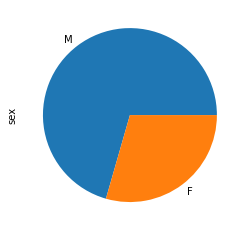

In [15]:
sex_distribution = df_players[["name", "sex"]]["sex"].value_counts()
print(sex_distribution)
sex_distribution.plot(kind="pie");

###**Assign age**

We decided to assign the last age from a tournament to each player.

In [16]:
def __birth_date(age, a_date):
    days = datetime.timedelta(math.ceil(age * 365) + int(age / 4))
    return a_date - days


def birth_date_calc(player_with_ages, new_ds):
    new_ds.insert(len(new_ds.columns), 'birth_date', np.NaN)
    for _, x in player_with_ages.iterrows():
        b_d = __birth_date(x['age'], x['tourney_date'])
        new_ds.loc[new_ds['name'] == x['name'], 'birth_date'] = b_d
    new_ds['birth_date'] = pd.to_datetime(new_ds['birth_date'], errors='coerce').dt.date

def retrieve_age_and_tourdate(df_matches):
  win_with_age = df_matches[df_matches['winner_age'].notna()][
        ['winner_name', 'winner_age', 'tourney_date']]

  loser_with_age = df_matches[df_matches['loser_age'].notna()][
      ['loser_name', 'loser_age', 'tourney_date']]
  loser_with_age.rename(columns={'loser_name': 'winner_name', 'loser_age': 'winner_age'}, inplace=True)

  ris = win_with_age.append(loser_with_age).drop_duplicates(subset='winner_name')
  ris.rename(columns={'winner_name': 'name', 'winner_age': 'age'}, inplace=True)
  return ris
        

In [17]:
def get_players_last_age(df_matches):
    win_pl_feat = df_matches[['winner_name', 'winner_age']]
    los_pl_feat = df_matches[['loser_name', 'loser_age']]
    tot: pd.DataFrame = win_pl_feat.rename(columns={'winner_name': 'name', 'winner_age': 'age'}).append(
        los_pl_feat.rename(columns={'loser_name': 'name', 'loser_age': 'age'}))
    tot = tot.groupby('name').max()
    tot['age'] = np.floor(tot['age']).astype("Int32", errors="raise")
    return tot

def age_sampling(player_ages: pd.DataFrame):
    ages = player_ages['age']
    m_age, d_age = ages.mean(), ages.std()
    sampled = []
    for n in ages[ages.isna()].iteritems():
        s = np.random.normal(m_age, d_age)
        s = np.where(s >= m_age - d_age, s, 2 * m_age - s)
        n = n[0]
        ages.loc[n] = int(s)
        sampled.append((n, s))
    return sampled

def age_assignment(df_players, player_age):
    df_players.insert(len(df_players.columns), 'age', 0)
    for n, a in player_age.itertuples():
      df_players.loc[df_players['name'] == n, 'age'] = a

In [18]:
player_with_ages = retrieve_age_and_tourdate(df_matches)
print("There are {0} players with no known age".format(len(players)-len(player_with_ages)))

There are 56 players with no known age


We sample the age for those missing this value and we proceed with age assignment to the player profile.

In [19]:
player_age = get_players_last_age(df_matches)
sampled_age = age_sampling(player_age)
age_assignment(df_players, player_age)

In [20]:
df_players

,name,sex,age
0,alexander zverev,M,24
1,jeff greenwald,M,51
2,agustin moreno,M,48
3,martin damm,M,17
4,wei yu su,M,40
...,...,...,...
4254,david o hare,M,27
4255,kuan-yi lee,M,23
4256,ben patael,M,22
4257,andres artunedo martinavarro,M,25


In [21]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4255 entries, 0 to 4258
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4255 non-null   object
 1   sex     4255 non-null   object
 2   age     4255 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 133.0+ KB


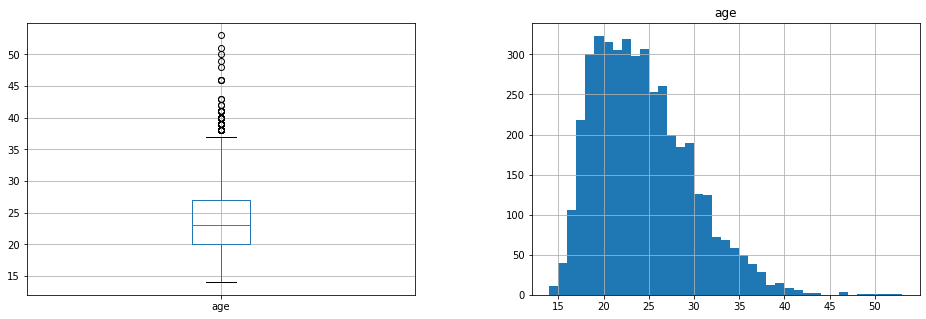

In [22]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="age", ax=ax1)
df_players.hist(column="age", ax=ax2, stacked=True, bins=39)
fig.subplots_adjust(wspace=0.3)

The outliers have the actual age, so don't need to change them.

###**Assign ioc**

From the data understanding task we know that each player has only one ioc, so we only have to assign them the right one by looking at the match dataset.

In [23]:
w_ioc = df_matches[["winner_name", "winner_ioc"]].rename(columns={"winner_name": "name", "winner_ioc": "ioc"})
l_ioc = df_matches[["loser_name", "loser_ioc"]].rename(columns={"loser_name": "name", "loser_ioc": "ioc"})
players_ioc = w_ioc.append(l_ioc).drop_duplicates()
players_ioc

,name,ioc
0,kei nishikori,JPN
1,daniil medvedev,RUS
3,jo-wilfried tsonga,FRA
5,jeremy chardy,FRA
8,alex de minaur,AUS
...,...,...
177178,ellie douglas,USA
177223,brittany collens,USA
177445,barbora palicova,CZE
177446,kristyna lavickova,CZE


In [24]:
df_players.insert(len(df_players.columns), 'ioc', np.NaN)
for _, player in players_ioc.iterrows():
    df_players.loc[df_players["name"] == player["name"], "ioc"] = player["ioc"]

Let's show how many player are in each country.

In [25]:
ioc_distribution = df_players["ioc"].value_counts()
ioc_distribution

USA    425
ITA    259
FRA    239
AUS    174
DEU    168
      ... 
SYR      1
BEN      1
TOG      1
PNG      1
HTI      1
Name: ioc, Length: 123, dtype: int64

In [26]:
fig = plt_go.Figure(
    data=plt_go.Choropleth(
        locations=ioc_distribution.index,
        z=ioc_distribution, 
        colorbar_title='Player per ioc',))
fig.update_layout(title_text='Number of players per country')

fig.show()

###**Assign height**

There are many players without height, we decided to sample them from distributions based on country and sex.

In [27]:
w_ht = df_matches[["winner_name", "winner_ht"]].rename(columns={"winner_name": "name", "winner_ht": "ht"})
l_ht = df_matches[["loser_name", "loser_ht"]].rename(columns={"loser_name": "name", "loser_ht": "ht"})
players_ht = w_ht.append(l_ht).drop_duplicates()
players_ht

,name,ht
0,kei nishikori,178
1,daniil medvedev,198
3,jo-wilfried tsonga,188
5,jeremy chardy,188
8,alex de minaur,183
...,...,...
177178,ellie douglas,<NA>
177223,brittany collens,<NA>
177445,barbora palicova,<NA>
177446,kristyna lavickova,<NA>


Let's assign the height to those players for which we could retrieve it.

In [28]:
df_players.insert(len(df_players.columns), 'ht', np.NaN)
df_players["ht"] = df_players["ht"].astype("Int64", errors="ignore")
for _, player in players_ht[players_ht["ht"].notna()].iterrows():
    df_players.loc[df_players["name"] == player["name"], "ht"] = player["ht"]

In [29]:
print("Players with no height: {0}".format(len(df_players[df_players["ht"].isna()])))

Players with no height: 3721


In [30]:
players_no_ht = df_players[df_players["ht"].isna()]
players_no_ht

,name,sex,age,ioc,ht
1,jeff greenwald,M,51,USA,<NA>
3,martin damm,M,17,USA,<NA>
4,wei yu su,M,40,TWN,<NA>
5,gergely kisgyorgy,M,40,HUN,<NA>
17,alessandro motti,M,42,ITA,<NA>
...,...,...,...,...,...
4254,david o hare,M,27,IRL,<NA>
4255,kuan-yi lee,M,23,TWN,<NA>
4256,ben patael,M,22,ISR,<NA>
4257,andres artunedo martinavarro,M,25,ESP,<NA>


In [31]:
# p_ht_ioc = df_players.groupby(["ioc", "sex"]).count()["ht"]
# p_ht_ioc.mean() + 3 * p_ht_ioc.std()

We need to sample the heights from various distribution per country.

In [32]:
p_ht_ioc = df_players.groupby(["ioc", "sex"]).count()["ht"]
p_mean_ht_ioc = df_players.groupby(["ioc", "sex"]).mean()["ht"] 
p_std_ht_ioc = df_players.groupby(["ioc", "sex"]).std()["ht"]
p_mean_ht_sex = df_players.groupby("sex").mean()["ht"] 
p_std_ht_sex = df_players.groupby("sex").std()["ht"]
for _, player in players_no_ht.iterrows():
    ioc, sex = player[["ioc", "sex"]]
    n_players = p_ht_ioc.loc[(ioc, sex)]
    if n_players > 10:
        mean = p_mean_ht_ioc.loc[(ioc,  sex)]
        std = p_std_ht_ioc.loc[(ioc, sex)]
    else:
        mean = p_mean_ht_sex.loc[sex]
        std = p_std_ht_sex.loc[sex]

    df_players.loc[df_players["name"]==player["name"], "ht"] = int(np.random.normal(mean, std))

Let's now plot the graph for both male and female.

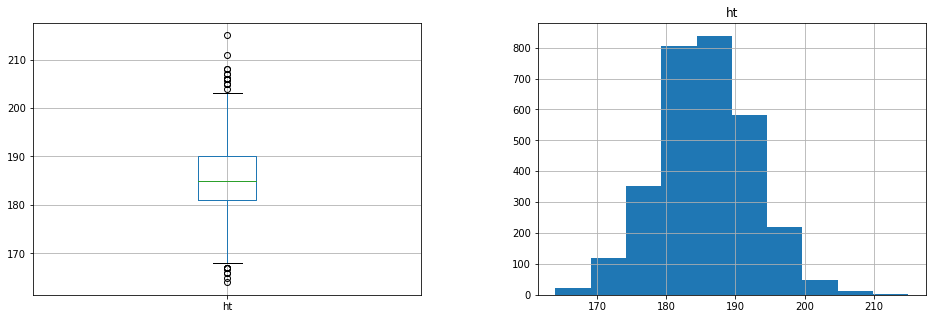

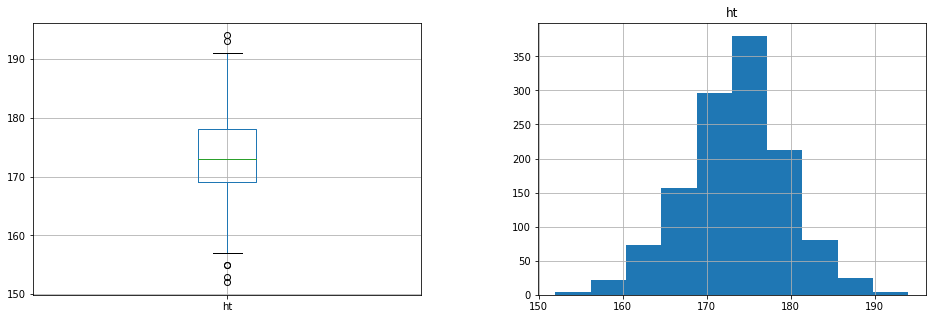

In [33]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players[df_players["sex"]=="M"].boxplot(column="ht", ax=ax1)
df_players[df_players["sex"]=="M"].hist(column="ht", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players[df_players["sex"]=="F"].boxplot(column="ht", ax=ax1)
df_players[df_players["sex"]=="F"].hist(column="ht", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

###**Assign hand**

Since there were no players with more than one hand we can assign them.

In [34]:
w_hand = df_matches[["winner_name", "winner_hand"]].rename(columns={"winner_name": "name", "winner_hand": "hand"})
l_hand = df_matches[["loser_name", "loser_hand"]].rename(columns={"loser_name": "name", "loser_hand": "hand"})
players_hand = w_hand.append(l_hand).drop_duplicates()
players_hand

,name,hand
0,kei nishikori,R
1,daniil medvedev,R
3,jo-wilfried tsonga,R
5,jeremy chardy,R
8,alex de minaur,R
...,...,...
177178,ellie douglas,U
177223,brittany collens,R
177445,barbora palicova,R
177446,kristyna lavickova,U


In [35]:
df_players.insert(len(df_players.columns), 'hand', np.NaN)
for _, player in players_hand.iterrows():
    df_players.loc[df_players["name"] == player["name"], "hand"] = player["hand"]

R    2134
U    1839
L     282
Name: hand, dtype: int64


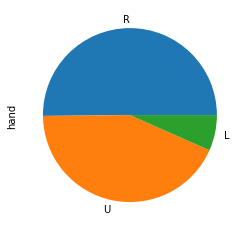

In [36]:
hand_distribution = df_players["hand"].value_counts()
print(hand_distribution)
hand_distribution.plot(kind="pie")

###**Calculate wins and losses**

For each player we calculate how many times he won or lost by looking at the matches dataset.

In [37]:
def count_wins_losses(feature, feature_type):
    if feature_type not in ["winner", "loser"]:
        raise ValueError("The type must be winner or loser")
    
    r = df_matches[feature_type+"_name"].value_counts()
    for player, n in r.iteritems():
        df_players.loc[df_players['name'] == player, feature] = n

Insert the corresponding features in the players profile.

In [38]:
df_players.insert(len(df_players.columns), "wins", 0)
df_players.insert(len(df_players.columns), "losses", 0)
df_players["wins"] = df_players["wins"].astype("Int64", errors="ignore")
df_players["losses"] = df_players["losses"].astype("Int64", errors="ignore")

Calculate wins and losses for each player.

In [39]:
count_wins_losses("wins", "winner")
count_wins_losses("losses", "loser")

Plot the features' distribution.

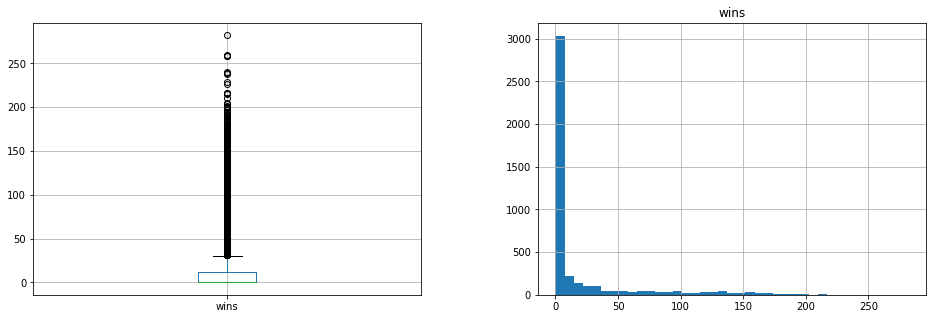

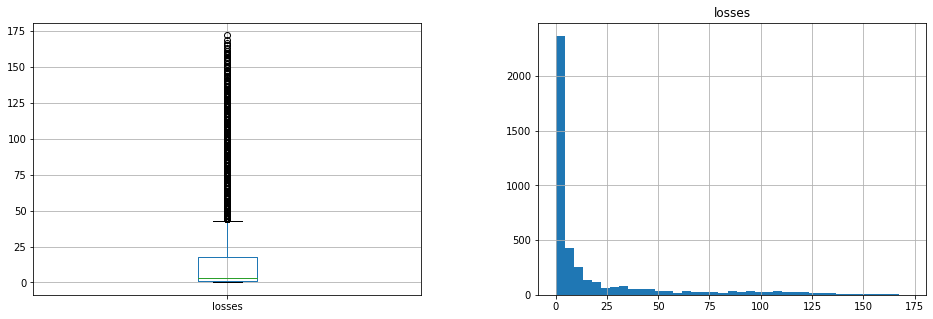

In [40]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="wins", ax=ax1)
df_players.hist(column="wins", ax=ax2, stacked=True, bins=39)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="losses", ax=ax1)
df_players.hist(column="losses", ax=ax2, stacked=True, bins=39)
fig.subplots_adjust(wspace=0.3)

###**Calculate tournaments won**

To obtain such feature we look calculate how many times a player appears as a winner in a final.

In [41]:
def count_finals_by_player(count_winner=True):
    feat = {True: ['winner_name', 't_won'],
            False: ['loser_name', 'finals_lost']}
    feat = feat[count_winner]
    tourn_finals = df_matches[['tourney_id', feat[0], 'round']].drop_duplicates()
    tourn_finals = tourn_finals[tourn_finals['round'] == 'F']
    n_tournament_won_by_player: pd.Series = tourn_finals[feat[0]].value_counts()
    for x in n_tournament_won_by_player.iteritems():
        player, t_w = x[0], x[1]
        df_players.loc[df_players['name'] == player, feat[1]] = t_w

In [42]:
df_players.insert(len(df_players.columns), "t_won", 0)
df_players["t_won"] = df_players["t_won"].astype("Int64", errors="ignore")
count_finals_by_player()

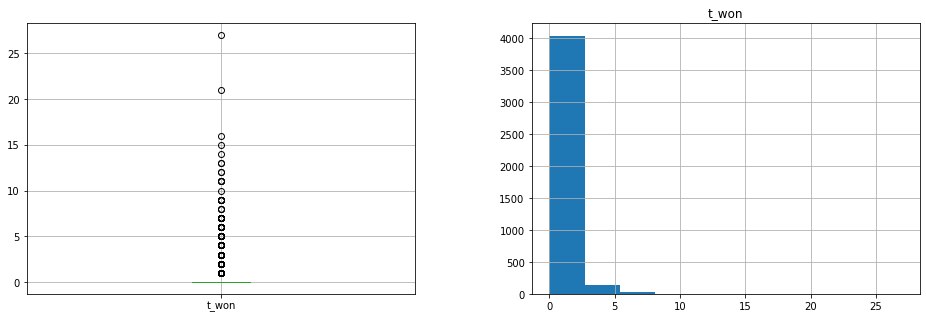

In [43]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="t_won", ax=ax1)
df_players.hist(column="t_won", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

It seems a very skewed distribution, but this is perfectly normal since there few players that have won at least one tournament.

Is it normal that many players didn't win any tournaments, so we can proceed with our work.

###**Calculate statistics for each surface**

We want to know how many matches each player has played and won on each surface.

In [44]:
def compute_surface_statistics():
    w_match_surface = df_matches[['surface', 'winner_name']]
    l_match_surface = df_matches[['surface', 'loser_name']]
    win_per_surf = []
    for _, surface in w_match_surface['surface'].drop_duplicates().iteritems():
        win_in_surf = w_match_surface[w_match_surface['surface'] == surface]
        los_in_surf = l_match_surface[l_match_surface['surface'] == surface]
        matches = win_in_surf['winner_name'].append(los_in_surf['loser_name']).value_counts()
        win = win_in_surf['winner_name'].value_counts()
        win_per_surf.append((surface, win, matches))
        
    for surface, matches_won, matches in win_per_surf:
        new_attr = 'w_' + surface
        new_attr_matches = 'n_' + surface
        df_players.insert(len(df_players.columns), new_attr, 0)
        df_players.insert(len(df_players.columns), new_attr_matches, 0)
        df_players[new_attr] = df_players[new_attr].astype("Int64", errors="ignore")
        df_players[new_attr_matches] = df_players[new_attr_matches].astype("Int64", errors="ignore")
        for w_ply, n_win in matches_won.iteritems():
            df_players.loc[df_players['name'] == w_ply, new_attr] = n_win
        for ply, n_match in matches.iteritems():
            df_players.loc[df_players['name'] == ply, new_attr_matches] = n_match

In [45]:
compute_surface_statistics()

We need to drop the statistics about the carpet surface since only few matches were played on it and that surface isn't present anymore in any tournament (source: https://tennisworldlive.com/tennis-tournaments-no-longer-played-carpet/).

In [46]:
df_players[df_players["n_Carpet"]!=0][["w_Carpet"]].sum()

w_Carpet    11
dtype: int64

In [47]:
df_players = df_players.drop(["w_Carpet", "n_Carpet"], axis=1)

###**Calculate each statistics**

We calculate the statistics (the ones in the cleaned matches dataset) for each player.

In [48]:
def assign_stat_feature(feature, new_feature):
    w_feature = "w_" + feature
    l_feature = "l_" + feature
    w_player_feature = df_matches[['winner_name', w_feature]].rename(columns={"winner_name": "name", w_feature: new_feature})
    l_player_feature = df_matches[['loser_name', l_feature]].rename(columns={'loser_name': 'name', l_feature: new_feature})
    features = w_player_feature.append(l_player_feature)
    features = features.groupby("name").sum()
    df_players.insert(len(df_players.columns), new_feature, 0)
    df_players[new_feature] = df_players[new_feature].astype("Int64", errors="ignore")
    for player, n_feature in features.iterrows():
        df_players.loc[df_players["name"] == player, new_feature] = n_feature[new_feature]

In [49]:
assign_stat_feature("ace", "aces")
assign_stat_feature("df", "double_faults")
assign_stat_feature("svpt", "serve_points")
assign_stat_feature("1stIn", "1st_in")
assign_stat_feature("1stWon", "1st_won")
assign_stat_feature("2ndWon", "2nd_won")
assign_stat_feature("SvGms", "serve_games")
assign_stat_feature("bpSaved", "bp_saved")
assign_stat_feature("bpFaced", "bp_faced")

###**Assign rank**

In [50]:
w_player_rank = df_matches[["tourney_date",'winner_name', 'winner_rank']].rename(columns={'winner_name': 'name', 'winner_rank': 'rank'})
l_player_rank = df_matches[["tourney_date", 'loser_name', 'loser_rank']].rename(columns={'loser_name': 'name', 'loser_rank': 'rank'})
ranks = w_player_rank.append(l_player_rank).drop_duplicates().sort_values(["name", "tourney_date"])
ranks

,tourney_date,name,rank
76205,2017-07-24,aaro pollanen,1559
74244,2016-01-11,aaron addison,1255
72902,2016-02-01,aaron addison,1254
71687,2016-10-24,aaron addison,1037
75587,2016-10-31,aaron addison,1047
...,...,...,...
97905,2019-09-09,zuzana zlochova,342
177465,2020-08-31,zuzana zlochova,317
177121,2021-07-05,zuzana zlochova,344
99909,2021-07-12,zuzana zlochova,351


Insert the new feature in the players' profile.

In [51]:
df_players.insert(len(df_players.columns), "rank", 0)
df_players["rank"] = df_players["rank"].astype("Int64", errors="ignore")

Fill the records (players) with the rank from the last tournament they played in.

In [52]:
for _, player in df_players.iterrows():
    tourneys_played = ranks[ranks["name"]==player["name"]][["tourney_date", "rank"]]
    last_tourney_played = tourneys_played.iloc[-1]
    df_players.loc[df_players["name"]==player["name"], "rank"] = last_tourney_played["rank"]

Plot the distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e849e4290>]],
      dtype=object)

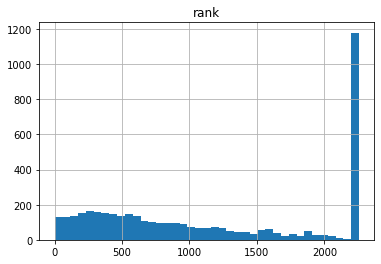

In [53]:
df_players.hist(column="rank", stacked=True, bins=39)

The distribution is extremely skewed given the fact that there were many players without any rank to which we assigned the same value, those players have played very few matches too, so we decided to drop them.

38.53443008225617
4.0
73.54657461980334


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e848bb090>]],
      dtype=object)

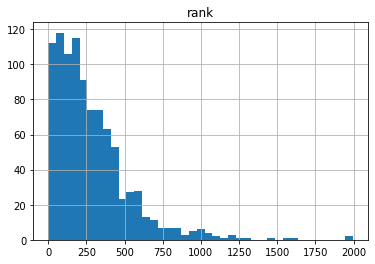

In [54]:
df_players_matches = [df_players["wins"] + df_players["losses"]]
print(np.mean(df_players_matches))
print(np.median(df_players_matches))
print(np.std(df_players_matches))
# df_players[df_players["wins"] + df_players["losses"]>=30]
df_players_matches = df_players.drop(index=df_players[df_players["wins"] + df_players["losses"]<=38].index)
df_players_matches.hist(column="rank", bins=39)

In [55]:
df_players_matches[df_players_matches["rank"]>1800]

,name,sex,age,ioc,ht,hand,wins,losses,t_won,w_Hard,n_Hard,w_Clay,n_Clay,w_Grass,n_Grass,aces,double_faults,serve_points,1st_in,1st_won,2nd_won,serve_games,bp_saved,bp_faced,rank
995,david vega hernandez,M,27,ESP,186,R,22,28,0,7,14,15,36,0,0,137,191,3397,2092,1377,611,528,200,369,1995
1124,hans hach verdugo,M,29,MEX,186,U,10,30,0,10,35,0,5,0,0,197,158,3018,1869,1279,536,453,185,302,1963


In [56]:
df_players = df_players.drop(index=df_players[df_players["wins"] + df_players["losses"]<10].index)
df_players

,name,sex,age,ioc,ht,hand,wins,losses,t_won,w_Hard,n_Hard,w_Clay,n_Clay,w_Grass,n_Grass,aces,double_faults,serve_points,1st_in,1st_won,2nd_won,serve_games,bp_saved,bp_faced,rank
0,alexander zverev,M,24,DEU,198,R,260,111,16,154,225,83,111,23,35,3227,1626,30089,19491,14530,5284,4861,1338,2197,5
8,frank moser,M,40,DEU,193,R,5,6,0,3,6,1,2,1,3,60,22,779,444,324,158,115,53,77,848
13,ruben ramirez hidalgo,M,41,ESP,183,R,46,42,0,11,19,35,69,0,0,328,307,6107,3509,2436,1255,915,383,624,341
14,tommy haas,M,39,DEU,188,R,6,14,0,0,3,4,12,2,5,95,82,1710,1047,719,357,256,111,162,248
15,toshihide matsui,M,41,JPN,180,R,20,33,0,19,49,1,4,0,0,292,188,3285,1910,1349,681,507,190,310,752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,alexandar lazov,M,29,BGR,183,U,17,15,0,3,9,14,23,0,0,130,115,2047,1267,860,375,323,141,231,828
4254,david o hare,M,27,IRL,190,U,4,11,0,3,13,0,0,1,2,86,97,1070,657,462,182,157,64,102,2221
4255,kuan-yi lee,M,23,TWN,186,R,16,18,0,16,33,0,1,0,0,94,67,2138,1451,954,342,340,133,227,573
4256,ben patael,M,22,ISR,193,U,16,23,0,10,22,6,17,0,0,175,116,2638,1618,1065,499,409,153,272,562


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e848514d0>]],
      dtype=object)

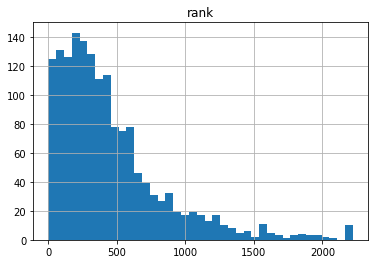

In [57]:
df_players.hist(column="rank", stacked=True, bins=39)

###**Assign ranking points**

In [58]:
w_player_rank_points = df_matches[["tourney_date",'winner_name', 'winner_rank_points']]\
.rename(columns={'winner_name': 'name', 'winner_rank_points': 'rank_points'})
l_player_rank_points = df_matches[["tourney_date", 'loser_name', 'loser_rank_points']]\
.rename(columns={'loser_name': 'name', 'loser_rank_points': 'rank_points'})
rank_points = w_player_rank_points.append(l_player_rank_points).drop_duplicates().sort_values(["name", "tourney_date"])
rank_points

,tourney_date,name,rank_points
76205,2017-07-24,aaro pollanen,2
74244,2016-01-11,aaron addison,6
72902,2016-02-01,aaron addison,6
71687,2016-10-24,aaron addison,10
75587,2016-10-31,aaron addison,10
...,...,...,...
97905,2019-09-09,zuzana zlochova,144
177465,2020-08-31,zuzana zlochova,166
177121,2021-07-05,zuzana zlochova,155
99909,2021-07-12,zuzana zlochova,157


In [59]:
df_players.insert(len(df_players.columns), "rank_points", 0)
df_players["rank_points"] = df_players["rank_points"].astype("Int64", errors="ignore")

In [60]:
for _, player in df_players.iterrows():
    tourneys_played = rank_points[rank_points["name"]==player["name"]][["tourney_date", "rank_points"]]
    last_tourney_played = tourneys_played.iloc[-1]
    df_players.loc[df_players["name"]==player["name"], "rank_points"] = last_tourney_played["rank_points"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e84e28110>]],
      dtype=object)

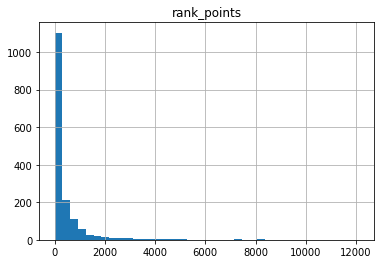

In [61]:
df_players.hist(column="rank_points", stacked=True, bins=39)

##**Correlations before introducing new features**

Now that we have gave each player the features coming from the cleaned matches dataset, we need to look at the correlations beetween them.

Let's take a first look to the new dataset (the players' profile).

In [62]:
df_players.head()

,name,sex,age,ioc,ht,hand,wins,losses,t_won,w_Hard,n_Hard,w_Clay,n_Clay,w_Grass,n_Grass,aces,double_faults,serve_points,1st_in,1st_won,2nd_won,serve_games,bp_saved,bp_faced,rank,rank_points
0,alexander zverev,M,24,DEU,198,R,260,111,16,154,225,83,111,23,35,3227,1626,30089,19491,14530,5284,4861,1338,2197,5,7263
8,frank moser,M,40,DEU,193,R,5,6,0,3,6,1,2,1,3,60,22,779,444,324,158,115,53,77,848,19
13,ruben ramirez hidalgo,M,41,ESP,183,R,46,42,0,11,19,35,69,0,0,328,307,6107,3509,2436,1255,915,383,624,341,142
14,tommy haas,M,39,DEU,188,R,6,14,0,0,3,4,12,2,5,95,82,1710,1047,719,357,256,111,162,248,205
15,toshihide matsui,M,41,JPN,180,R,20,33,0,19,49,1,4,0,0,292,188,3285,1910,1349,681,507,190,310,752,21


In [63]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           1600 non-null   object
 1   sex            1600 non-null   object
 2   age            1600 non-null   int64 
 3   ioc            1600 non-null   object
 4   ht             1600 non-null   Int64 
 5   hand           1600 non-null   object
 6   wins           1600 non-null   Int64 
 7   losses         1600 non-null   Int64 
 8   t_won          1600 non-null   Int64 
 9   w_Hard         1600 non-null   Int64 
 10  n_Hard         1600 non-null   Int64 
 11  w_Clay         1600 non-null   Int64 
 12  n_Clay         1600 non-null   Int64 
 13  w_Grass        1600 non-null   Int64 
 14  n_Grass        1600 non-null   Int64 
 15  aces           1600 non-null   Int64 
 16  double_faults  1600 non-null   Int64 
 17  serve_points   1600 non-null   Int64 
 18  1st_in         1600 non-null

Let's now plot the correlations beetween the features.

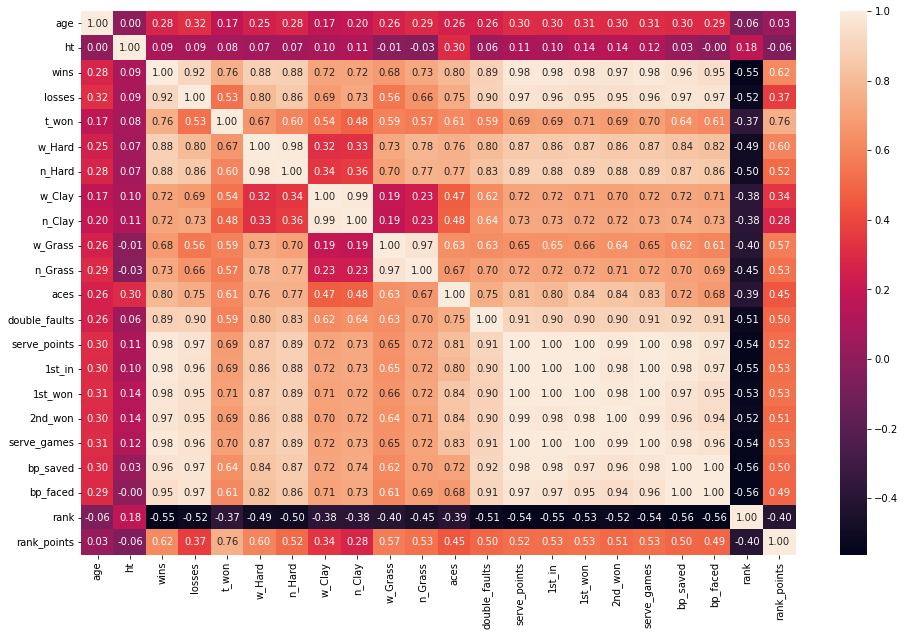

In [64]:
plt.pyplot.figure(figsize=(16, 10))
sn.heatmap(df_players.corr(), annot=True, fmt=".2f")

There are many higly-correlated features, we need to build new indicators from the ones we have and we have to drop those who we think are redundant or useless for the clustering analysis.

##**Building new features**

We need to define new features since the previous ones were to higly correlated.

The features we decided to build are some of the ones listed here https://www.atptour.com/en/stats.

In [65]:
df_players['n_matches'] = df_players['wins'] + df_players['losses']  # this will be dropped later
df_players['p_wins'] = np.round(df_players["wins"] / df_players["n_matches"]*100, 2)

# percentage of wins on each surface
df_players['p_w_Hard'] = np.round(df_players["w_Hard"] / df_players["n_Hard"]*100, 2)
df_players['p_w_Clay'] = np.round(df_players["w_Clay"] / df_players["n_Clay"]*100, 2)
df_players['p_w_Grass'] = np.round(df_players["w_Grass"] / df_players["n_Grass"]*100, 2)

# features for the aces
df_players['mean_aces'] = np.floor(df_players["aces"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_aces'] = np.round(df_players["aces"] / (df_players["serve_points"])*100, 2)

# features for the double faults
df_players['mean_double_faults'] = np.floor(df_players["double_faults"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_double_faults'] = np.round(df_players["double_faults"] / (df_players["serve_points"])*100, 2)

# features for the first service in
df_players['mean_1st_in'] = np.floor(df_players["1st_in"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_1st_in'] = np.round(df_players["1st_in"] / df_players["serve_points"]*100, 2)
df_players['mean_1st_won'] = np.floor(df_players["1st_won"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_1st_won'] = np.round(df_players["1st_won"] / df_players["1st_in"]*100, 2)

df_players['mean_2nd_won'] = np.floor(df_players["2nd_won"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_2nd_won'] = np.round(df_players["2nd_won"] / (df_players["serve_points"] - df_players["1st_in"])*100, 2)

# features for the breakpoints saved
df_players['mean_bp_saved'] = np.floor(df_players["bp_saved"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_bp_saved'] = np.round(df_players["bp_saved"] / df_players["bp_faced"]*100, 2)

# features that may be useless
df_players['mean_bp_faced'] = np.floor(df_players["bp_faced"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['mean_sv_games'] = np.floor(df_players["serve_games"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['mean_sv_points'] = np.floor(df_players["serve_points"] / df_players["n_matches"]).astype('Int32', errors='raise')

# fill the missing values
df_players=df_players.fillna(0)

We have to drop some of the previous features.

In [66]:
df_players = df_players.drop(["losses", "n_Hard", "n_Clay", "n_Grass",
                              "aces", "double_faults", "1st_in", "1st_won", "serve_points",
                              "2nd_won", "serve_games", "bp_saved", "bp_faced"], axis=1)

Order the features in the players' dataframe.

In [67]:
features = ["name", "sex", "age", "ioc", "ht", "hand", "t_won", "n_matches", "p_wins", "wins", "p_w_Hard", "w_Hard", "p_w_Clay", "w_Clay",
            "p_w_Grass", "w_Grass", "mean_aces", "p_aces", "mean_double_faults", "p_double_faults", "p_1st_in", "mean_1st_in", "p_1st_won", "mean_1st_won", "p_2nd_won", "mean_2nd_won",
            "mean_sv_points", "p_bp_saved", "mean_bp_saved", "mean_bp_faced", "mean_sv_games", "rank", "rank_points", ]
df_players = df_players[features]
df_players

,name,sex,age,ioc,ht,hand,t_won,n_matches,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,mean_aces,p_aces,mean_double_faults,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,mean_sv_games,rank,rank_points
0,alexander zverev,M,24,DEU,198,R,16,371,70.08,260,68.44,154,74.77,83,65.71,23,8,10.72,4,5.40,64.78,52,74.55,39,49.86,14,81,60.90,3,5,13,5,7263
8,frank moser,M,40,DEU,193,R,0,11,45.45,5,50.00,3,50.00,1,33.33,1,5,7.70,2,2.82,57.00,40,72.97,29,47.16,14,70,68.83,4,7,10,848,19
13,ruben ramirez hidalgo,M,41,ESP,183,R,0,88,52.27,46,57.89,11,50.72,35,0.00,0,3,5.37,3,5.03,57.46,39,69.42,27,48.31,14,69,61.38,4,7,10,341,142
14,tommy haas,M,39,DEU,188,R,0,20,30.00,6,0.00,0,33.33,4,40.00,2,4,5.56,4,4.80,61.23,52,68.67,35,53.85,17,85,68.52,5,8,12,248,205
15,toshihide matsui,M,41,JPN,180,R,0,53,37.74,20,38.78,19,25.00,1,0.00,0,5,8.89,3,5.72,58.14,36,70.63,25,49.53,12,61,61.29,3,5,9,752,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,alexandar lazov,M,29,BGR,183,U,0,32,53.12,17,33.33,3,60.87,14,0.00,0,4,6.35,3,5.62,61.90,39,67.88,26,48.08,11,63,61.04,4,7,10,828,16
4254,david o hare,M,27,IRL,190,U,0,15,26.67,4,23.08,3,0.00,0,50.00,1,5,8.04,6,9.07,61.40,43,70.32,30,44.07,12,71,62.75,4,6,10,2221,0
4255,kuan-yi lee,M,23,TWN,186,R,0,34,47.06,16,48.48,16,0.00,0,0.00,0,2,4.40,1,3.13,67.87,42,65.75,28,49.78,10,62,58.59,3,6,10,573,42
4256,ben patael,M,22,ISR,193,U,0,39,41.03,16,45.45,10,35.29,6,0.00,0,4,6.63,2,4.40,61.33,41,65.82,27,48.92,12,67,56.25,3,6,10,562,45


Plot the new features correlations.

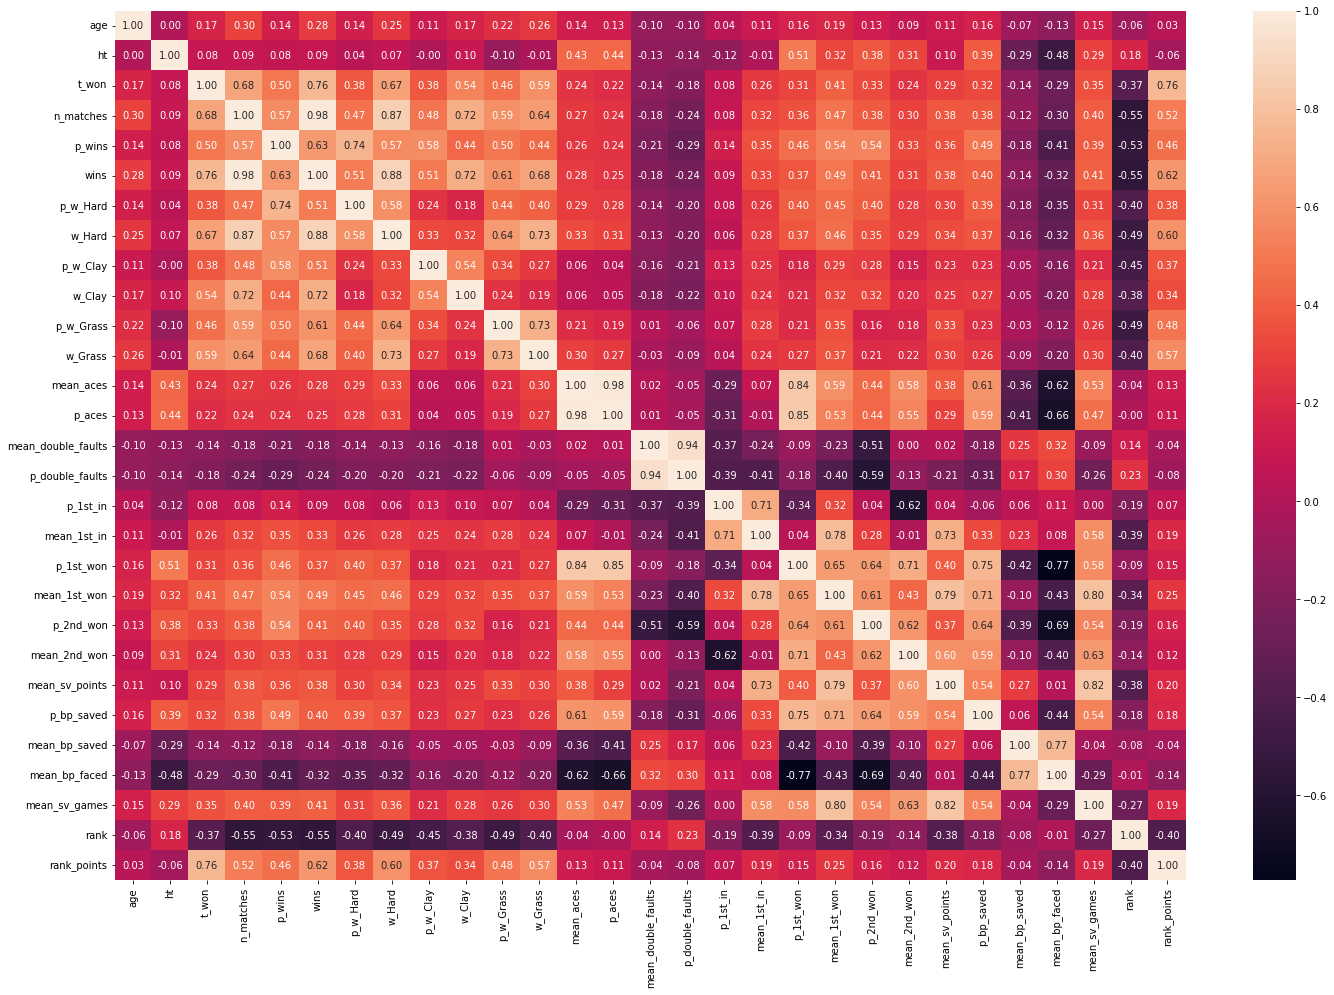

In [68]:
plt.pyplot.figure(figsize=(24, 16))
sn.heatmap(df_players.corr(), annot=True, fmt=".2f")

There are still some higly-correalted features.

In [69]:
features = df_players.corr().columns
correl_matrix = np.array(df_players.corr())
correl_attrib = []
n_row, n_col = correl_matrix.shape[0], correl_matrix.shape[1]

CORREL_THRESHOLD = 0.8

for i in range(n_row):
    for j in range(i + 1, n_col):
        if np.abs(correl_matrix[i, j]) > CORREL_THRESHOLD:
            correl_attrib.append((features[i], features[j]))

correl_attrib

[('n_matches', 'wins'),
 ('n_matches', 'w_Hard'),
 ('wins', 'w_Hard'),
 ('mean_aces', 'p_aces'),
 ('mean_aces', 'p_1st_won'),
 ('p_aces', 'p_1st_won'),
 ('mean_double_faults', 'p_double_faults'),
 ('mean_1st_won', 'mean_sv_games'),
 ('mean_sv_points', 'mean_sv_games')]

We decided to drop n_matches (which can be retrieved by p_wins and wins), mean_aces (there's no point in keeping it since we already have p_aces), mean_double_faults (same as for the aces) and mean_sv_games (since we didn't work with the scores). We won't drop w_hard since its high correlation with wins is given to the fact that most matches were played on that surface.

In [70]:
df_players = df_players.drop(["n_matches", "mean_aces", "mean_double_faults", "mean_sv_games"], axis=1)
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1600 non-null   object 
 1   sex              1600 non-null   object 
 2   age              1600 non-null   int64  
 3   ioc              1600 non-null   object 
 4   ht               1600 non-null   Int64  
 5   hand             1600 non-null   object 
 6   t_won            1600 non-null   Int64  
 7   p_wins           1600 non-null   float64
 8   wins             1600 non-null   Int64  
 9   p_w_Hard         1600 non-null   float64
 10  w_Hard           1600 non-null   Int64  
 11  p_w_Clay         1600 non-null   float64
 12  w_Clay           1600 non-null   Int64  
 13  p_w_Grass        1600 non-null   float64
 14  w_Grass          1600 non-null   Int64  
 15  p_aces           1600 non-null   float64
 16  p_double_faults  1600 non-null   float64
 17  p_1st_in      

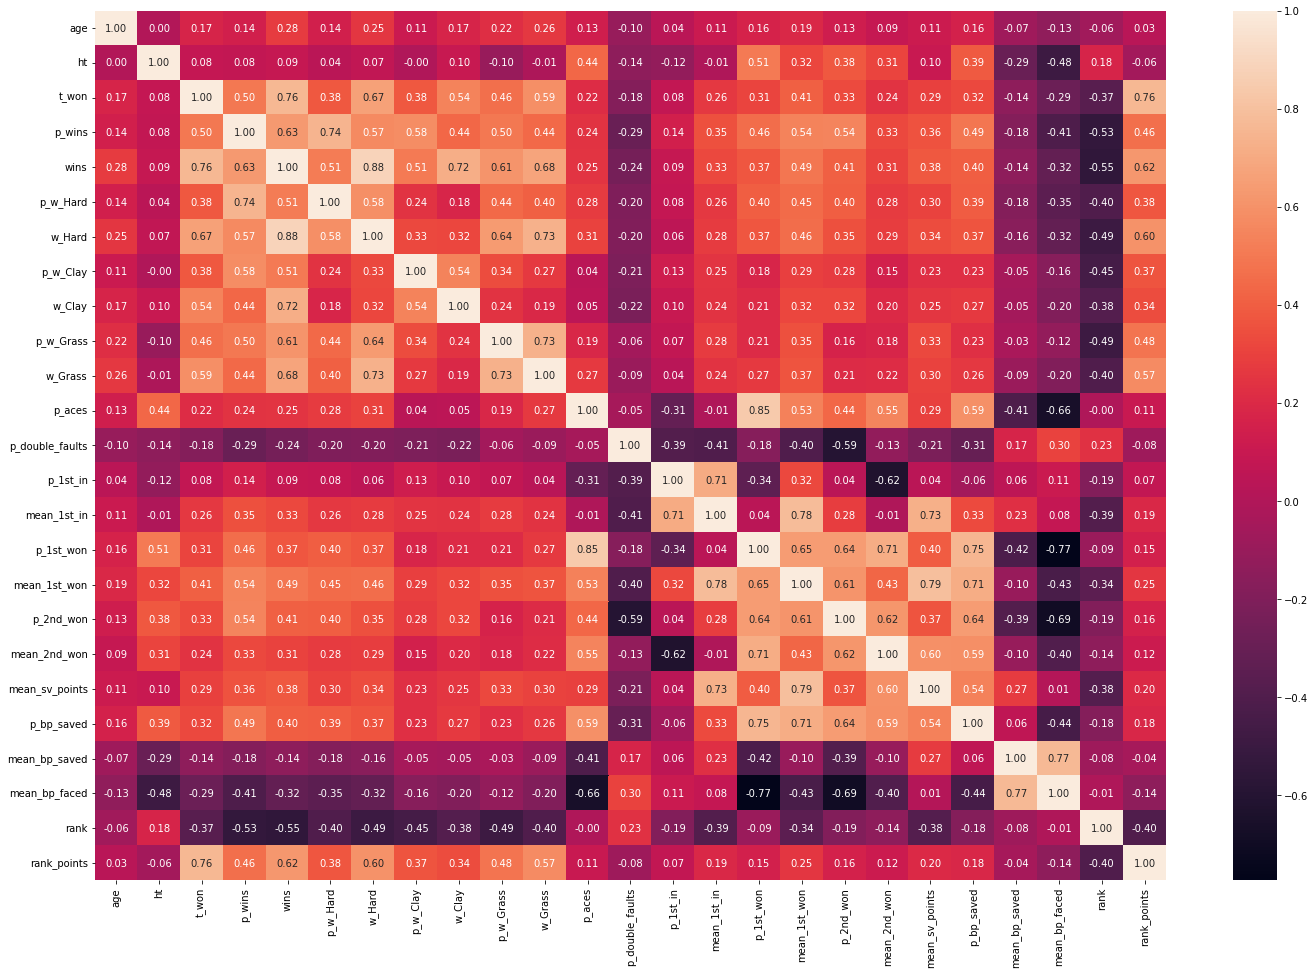

In [71]:
plt.pyplot.figure(figsize=(24, 16))
sn.heatmap(df_players.corr(), annot=True, fmt=".2f")

##**Statistical analysis of old and new features**

Before we save our dataset and work on the clustering analysis we need to show the distribution of the new built features.

In [72]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1600 non-null   object 
 1   sex              1600 non-null   object 
 2   age              1600 non-null   int64  
 3   ioc              1600 non-null   object 
 4   ht               1600 non-null   Int64  
 5   hand             1600 non-null   object 
 6   t_won            1600 non-null   Int64  
 7   p_wins           1600 non-null   float64
 8   wins             1600 non-null   Int64  
 9   p_w_Hard         1600 non-null   float64
 10  w_Hard           1600 non-null   Int64  
 11  p_w_Clay         1600 non-null   float64
 12  w_Clay           1600 non-null   Int64  
 13  p_w_Grass        1600 non-null   float64
 14  w_Grass          1600 non-null   Int64  
 15  p_aces           1600 non-null   float64
 16  p_double_faults  1600 non-null   float64
 17  p_1st_in      

###**"Old" features that are still used**

All the issues regarding the features from the cleaned matches daatset were already solved, we just plot their distribution.

####**Sex feature**

M    1102
F     498
Name: sex, dtype: int64


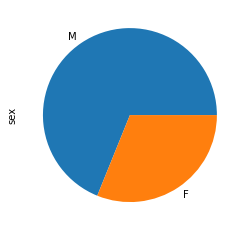

In [73]:
sex_distribution = df_players[["name", "sex"]]["sex"].value_counts()
print(sex_distribution)
sex_distribution.plot(kind="pie");

####**Age feature**

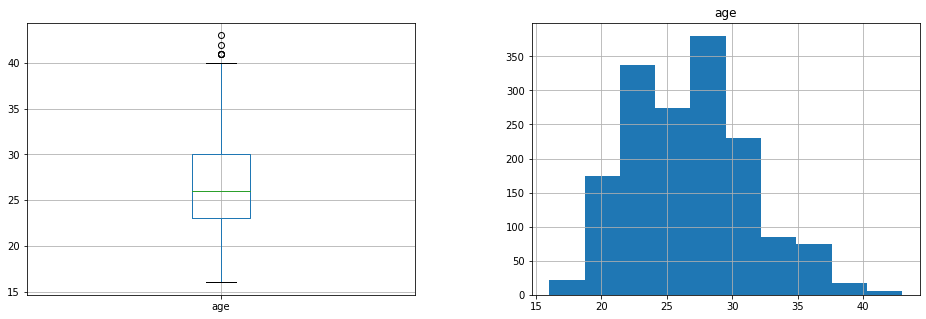

In [74]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="age", ax=ax1)
df_players.hist(column="age", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

As we already mentioned before, all the outliers have their correct age, so we dont need to change anything.

####**ioc feature**

In [75]:
ioc_distribution = df_players["ioc"].value_counts()
fig = plt_go.Figure(
    data=plt_go.Choropleth(
        locations=ioc_distribution.index,
        z=ioc_distribution, 
        colorbar_title='Player per ioc',))
fig.update_layout(title_text='Number of players per country')

fig.show()

####**Height feature**

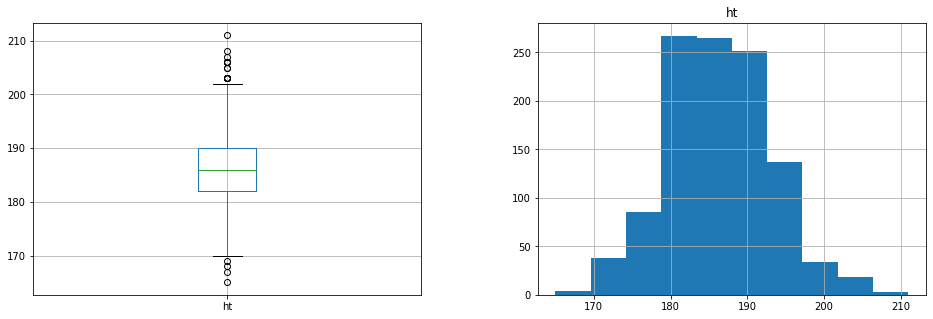

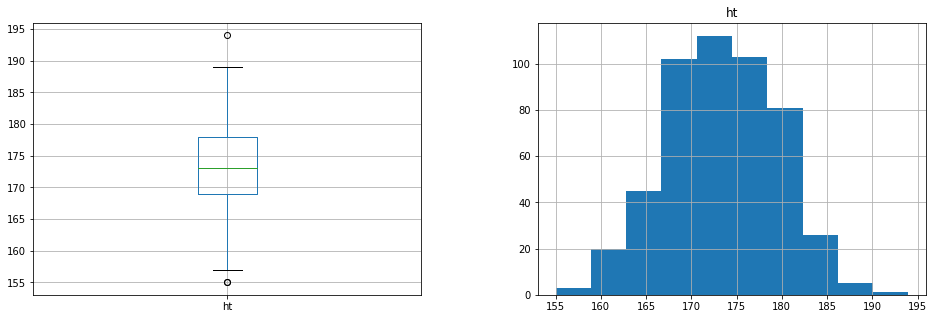

In [76]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players[df_players["sex"]=="M"].boxplot(column="ht", ax=ax1)
df_players[df_players["sex"]=="M"].hist(column="ht", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players[df_players["sex"]=="F"].boxplot(column="ht", ax=ax1)
df_players[df_players["sex"]=="F"].hist(column="ht", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

####**Hand feature**

R    1126
U     323
L     151
Name: hand, dtype: int64


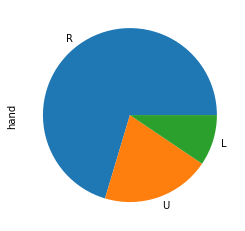

In [77]:
hand_distribution = df_players["hand"].value_counts()
print(hand_distribution)
hand_distribution.plot(kind="pie")

####**Tournaments won feature**

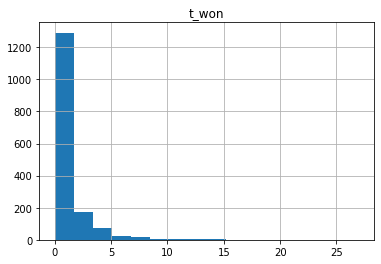

In [78]:
df_players.hist(column="t_won", stacked=True, bins=16);

####**Rank feature**

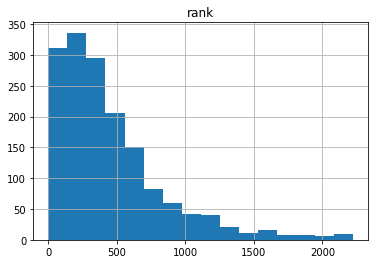

In [79]:
df_players.hist(column="rank", stacked=True, bins=16);

####**Rank points feature**

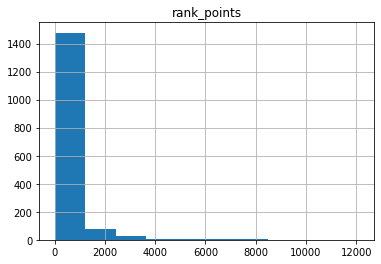

In [80]:
df_players.hist(column="rank_points", stacked=True, bins=10);

###**New features**

####**wins and percentage of wins**

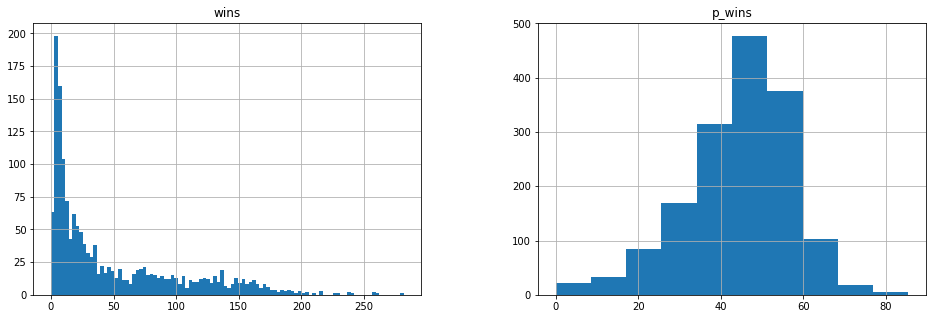

In [81]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.hist(column="wins", ax=ax1, stacked=True, bins=100)
df_players.hist(column="p_wins", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

####**wins and percentage of wins on each surface**

The players have played a total of 80398 matches:
46307 on Hard;
28978 on Grass;
5113 on Grass.


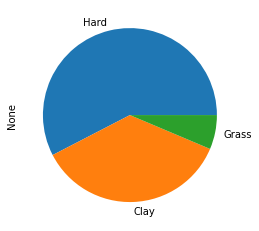

In [82]:
surface_distribution = []
surface_distribution.append(df_players["w_Hard"].sum())
surface_distribution.append(df_players["w_Clay"].sum())
surface_distribution.append(df_players["w_Grass"].sum())
print("The players have played a total of {0} matches:\n{1} on Hard;\n{2} on Grass;\n{3} on Grass.".format(np.sum(surface_distribution),surface_distribution[0], surface_distribution[1], surface_distribution[2]))
pd.Series(surface_distribution, ["Hard", "Clay", "Grass"]).plot(kind="pie");

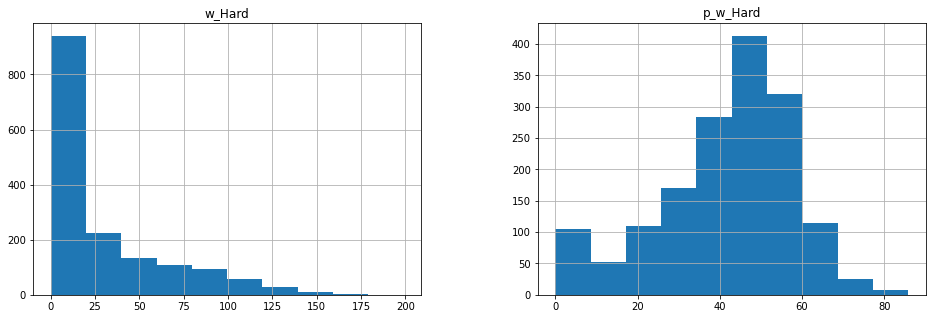

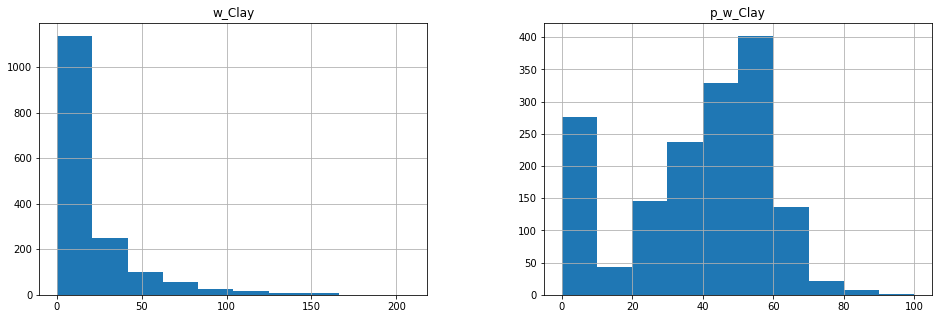

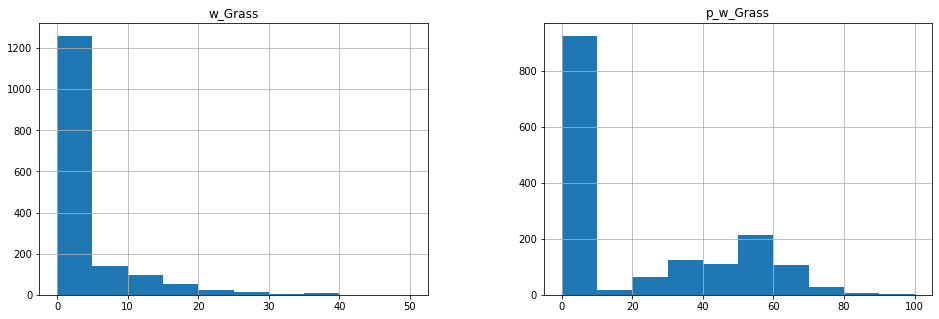

In [83]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.hist(column="w_Hard", ax=ax1, stacked=True, bins=10)
df_players.hist(column="p_w_Hard", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.hist(column="w_Clay", ax=ax1, stacked=True, bins=10)
df_players.hist(column="p_w_Clay", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.hist(column="w_Grass", ax=ax1, stacked=True, bins=10)
df_players.hist(column="p_w_Grass", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

####**aces percentage**

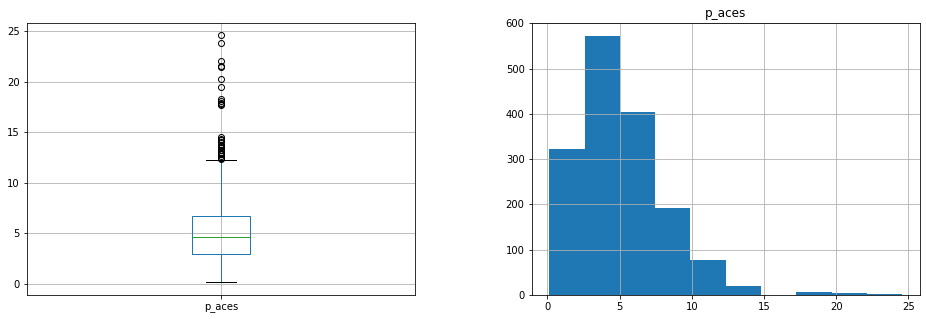

In [84]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="p_aces", ax=ax1)
df_players.hist(column="p_aces", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

In [85]:
df_players[df_players["p_aces"]>20]

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points
18,ivo karlovic,M,42,HRV,208,R,3,49.51,101,50.76,67,41.18,14,52.63,20,23.79,5.44,64.76,56,81.86,46,55.25,16,86,71.39,2,3,205,352
150,john isner,M,36,USA,206,R,6,62.17,166,61.03,119,60.47,26,72.41,21,24.57,2.61,70.54,62,79.39,49,57.41,14,88,71.12,2,3,26,2238
560,milos raonic,M,30,CAN,196,R,1,70.21,165,67.92,108,70.27,26,79.49,31,20.24,4.70,63.38,48,81.42,39,56.21,15,77,68.40,2,3,22,2338
598,tobias simon,M,30,DEU,186,R,0,51.58,49,53.95,41,33.33,5,75.00,3,21.40,6.34,60.47,44,80.95,36,53.27,15,73,62.39,2,3,426,96
650,albano olivetti,M,27,FRA,203,R,0,47.22,34,50.00,33,25.00,1,0.00,0,21.58,9.37,53.73,38,82.82,32,49.54,16,72,69.86,3,5,587,40
1360,reilly opelka,M,23,USA,211,R,6,56.47,131,58.93,99,54.00,27,35.71,5,22.08,4.02,62.40,50,79.67,40,54.66,16,81,68.18,2,3,23,2341


Most of those outliers are known for the strenght of their service and therefore their number of aces.

####**double faults percentage**

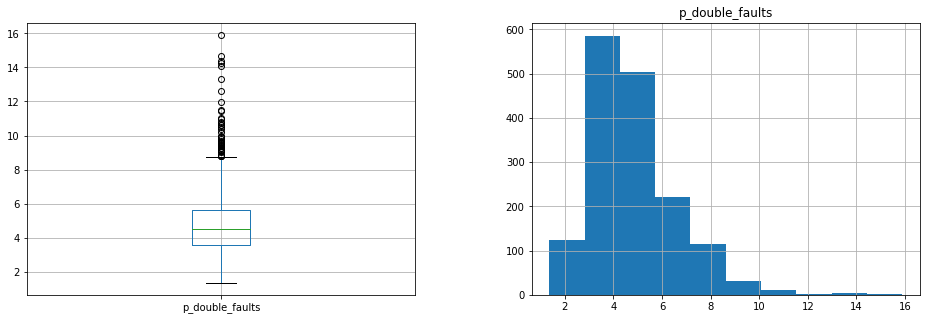

In [86]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="p_double_faults", ax=ax1)
df_players.hist(column="p_double_faults", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

####**mean and percentage of valid first serves**

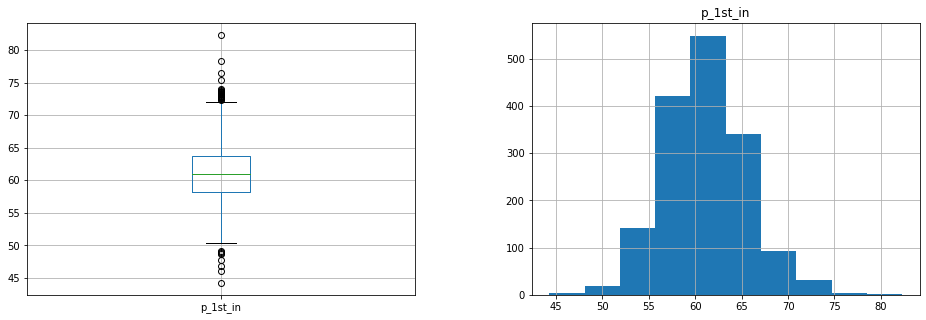

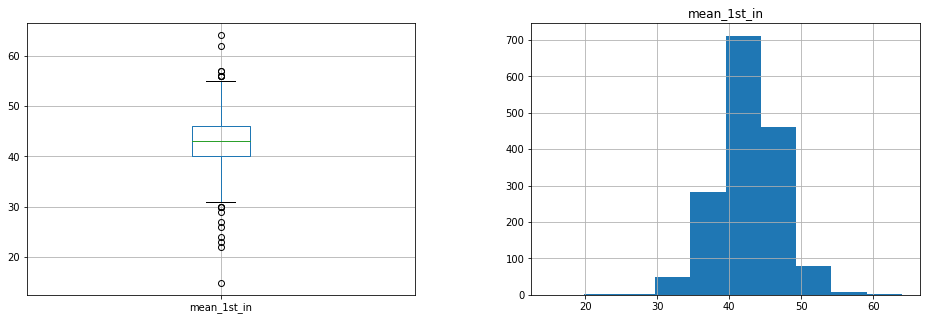

In [87]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="p_1st_in", ax=ax1)
df_players.hist(column="p_1st_in", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="mean_1st_in", ax=ax1)
df_players.hist(column="mean_1st_in", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

####**mean and percentage of first serves won**

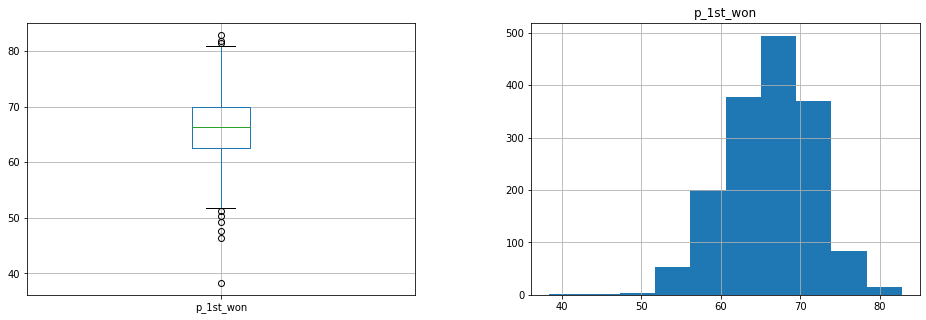

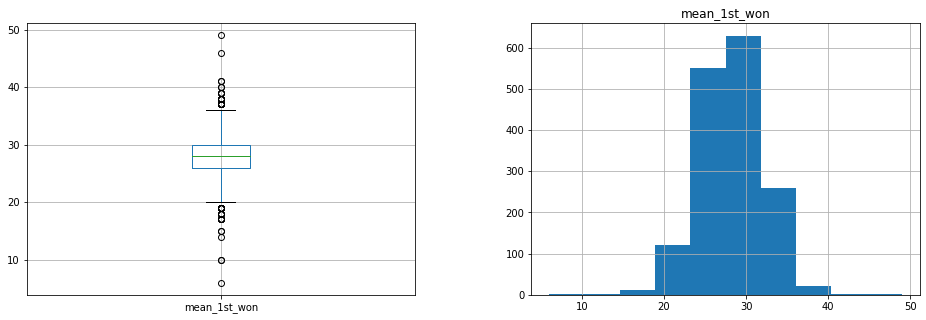

In [88]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="p_1st_won", ax=ax1)
df_players.hist(column="p_1st_won", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="mean_1st_won", ax=ax1)
df_players.hist(column="mean_1st_won", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

####**mean and percentage of second serves won**

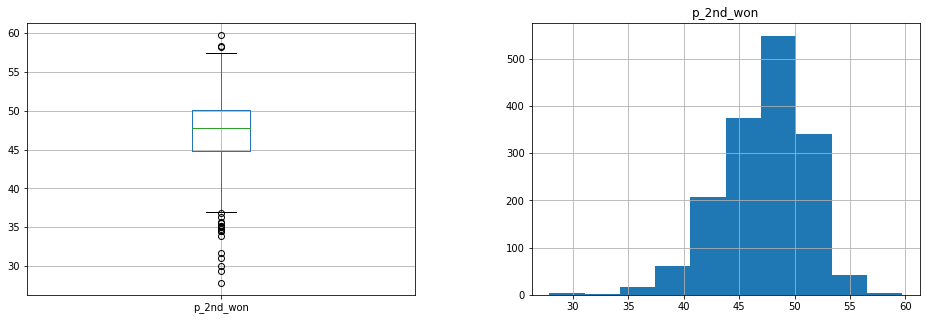

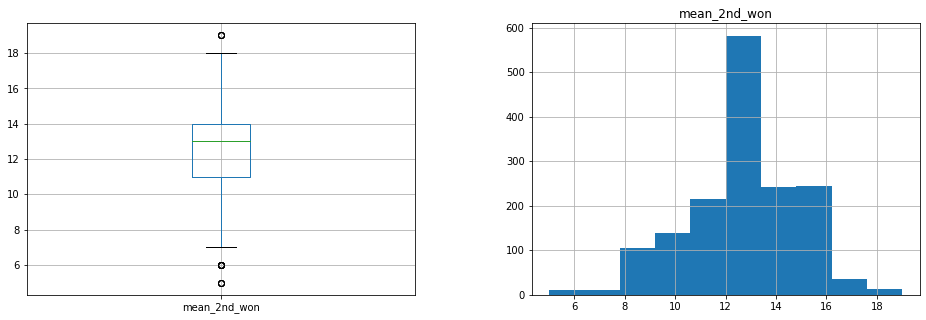

In [89]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="p_2nd_won", ax=ax1)
df_players.hist(column="p_2nd_won", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="mean_2nd_won", ax=ax1)
df_players.hist(column="mean_2nd_won", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

####**mean serve points**

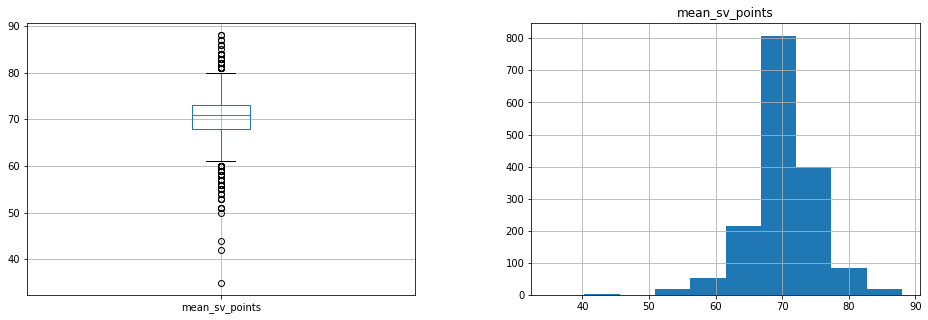

In [91]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="mean_sv_points", ax=ax1)
df_players.hist(column="mean_sv_points", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

####**mean of breakpoints faced and mean and percentage of breakpoints saved**

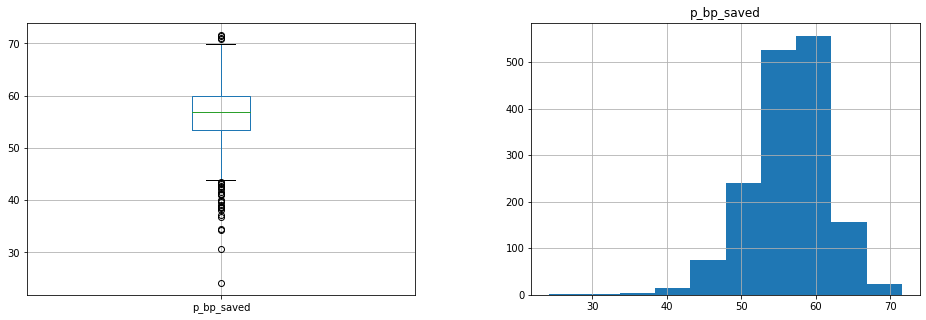

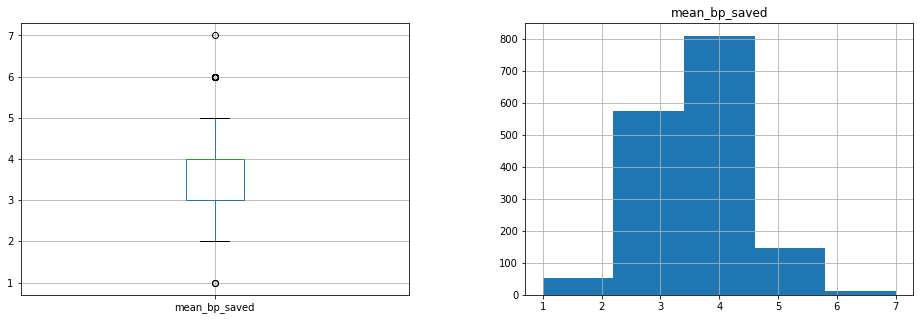

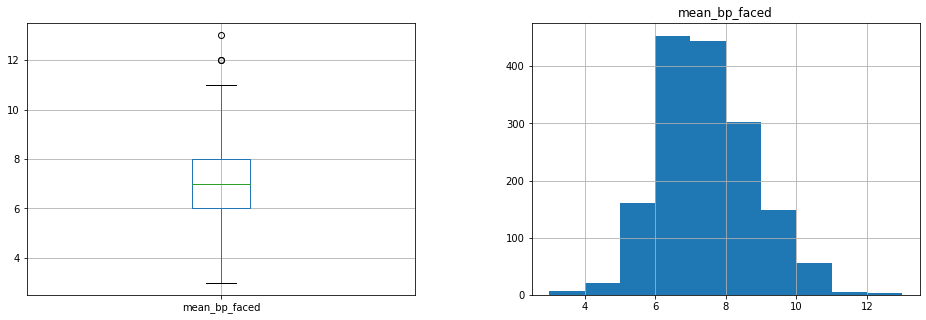

In [93]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="p_bp_saved", ax=ax1)
df_players.hist(column="p_bp_saved", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="mean_bp_saved", ax=ax1)
df_players.hist(column="mean_bp_saved", ax=ax2, stacked=True, bins=5)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="mean_bp_faced", ax=ax1)
df_players.hist(column="mean_bp_faced", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

####**rank and rank points**

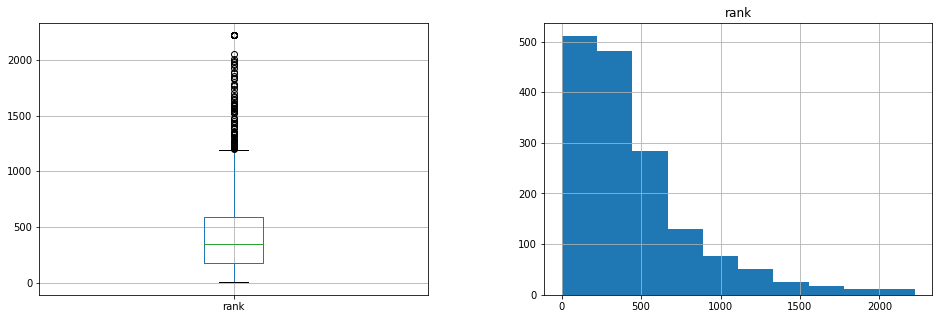

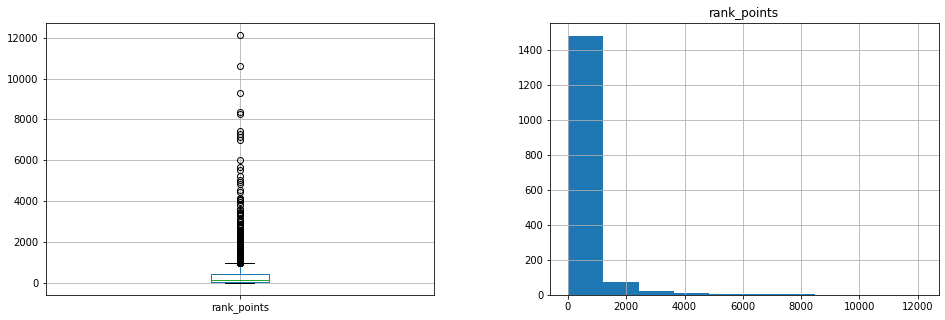

In [94]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="rank", ax=ax1)
df_players.hist(column="rank", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="rank_points", ax=ax1)
df_players.hist(column="rank_points", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

##**Save the players' profile**

We choose to save the cleaned dataframe in a gzip file since it mantains the dtypes (which the csv format doesn't), we show briefly an overview of the dataset before saving it.

In [95]:
df_players

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points
0,alexander zverev,M,24,DEU,198,R,16,70.08,260,68.44,154,74.77,83,65.71,23,10.72,5.40,64.78,52,74.55,39,49.86,14,81,60.90,3,5,5,7263
8,frank moser,M,40,DEU,193,R,0,45.45,5,50.00,3,50.00,1,33.33,1,7.70,2.82,57.00,40,72.97,29,47.16,14,70,68.83,4,7,848,19
13,ruben ramirez hidalgo,M,41,ESP,183,R,0,52.27,46,57.89,11,50.72,35,0.00,0,5.37,5.03,57.46,39,69.42,27,48.31,14,69,61.38,4,7,341,142
14,tommy haas,M,39,DEU,188,R,0,30.00,6,0.00,0,33.33,4,40.00,2,5.56,4.80,61.23,52,68.67,35,53.85,17,85,68.52,5,8,248,205
15,toshihide matsui,M,41,JPN,180,R,0,37.74,20,38.78,19,25.00,1,0.00,0,8.89,5.72,58.14,36,70.63,25,49.53,12,61,61.29,3,5,752,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,alexandar lazov,M,29,BGR,183,U,0,53.12,17,33.33,3,60.87,14,0.00,0,6.35,5.62,61.90,39,67.88,26,48.08,11,63,61.04,4,7,828,16
4254,david o hare,M,27,IRL,190,U,0,26.67,4,23.08,3,0.00,0,50.00,1,8.04,9.07,61.40,43,70.32,30,44.07,12,71,62.75,4,6,2221,0
4255,kuan-yi lee,M,23,TWN,186,R,0,47.06,16,48.48,16,0.00,0,0.00,0,4.40,3.13,67.87,42,65.75,28,49.78,10,62,58.59,3,6,573,42
4256,ben patael,M,22,ISR,193,U,0,41.03,16,45.45,10,35.29,6,0.00,0,6.63,4.40,61.33,41,65.82,27,48.92,12,67,56.25,3,6,562,45


In [96]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1600 non-null   object 
 1   sex              1600 non-null   object 
 2   age              1600 non-null   int64  
 3   ioc              1600 non-null   object 
 4   ht               1600 non-null   Int64  
 5   hand             1600 non-null   object 
 6   t_won            1600 non-null   Int64  
 7   p_wins           1600 non-null   float64
 8   wins             1600 non-null   Int64  
 9   p_w_Hard         1600 non-null   float64
 10  w_Hard           1600 non-null   Int64  
 11  p_w_Clay         1600 non-null   float64
 12  w_Clay           1600 non-null   Int64  
 13  p_w_Grass        1600 non-null   float64
 14  w_Grass          1600 non-null   Int64  
 15  p_aces           1600 non-null   float64
 16  p_double_faults  1600 non-null   float64
 17  p_1st_in      

In [99]:
df_players.to_parquet("players_dataset.gzip")

# with zipfile.ZipFile("preparation_data.zip", "w") as zip_ref:
    # zip_ref.write("male_players.csv")
    # zip_ref.write("female_players.csv")
    # zip_ref.write("cleaned_tennis_matches.gzip")